# Set Up

In [44]:
import cv2
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from time import perf_counter
from scipy.fftpack import dctn, idctn

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [45]:
original_gray_image = cv2.imread('grey_image.png', cv2.IMREAD_GRAYSCALE)

In [46]:
factors_to_show = [4, 64, 256]
keeps = np.concatenate([np.linspace(0.0009, 0.9999, 500), 1. / np.array(factors_to_show)])
keeps.sort()

# Metrics for Comparison

In [47]:
def average_time(method, *args, iters_number=10):
    times = []
    for i in range(iters_number):
        time_start = perf_counter()
        method(*args)
        time_stop = perf_counter()
        times.append(time_stop - time_start)
    return np.mean(times)

In [48]:
def compression_factor(size_original, size_compressed):
    return size_original / size_compressed

# Discrete Fourier Transform

In [49]:
def fourier_compress_image(original_image, keep):
    coeffs = np.fft.fft2(original_image)
    Csort = np.sort(np.abs(coeffs.reshape(-1)))

    thresh = Csort[int(np.floor((1 - keep) * len(Csort)))]
    ind = np.abs(coeffs) > thresh
    Cfiltered = coeffs * ind

    return Cfiltered

def fourier_reconstruct_image(coeffs):
    return np.fft.ifft2(coeffs)

def fourier_statistics(original_image, keep):
    Cfiltered = fourier_compress_image(original_image, keep)

    compr_time = average_time(fourier_compress_image, original_image, keep)
    compr_factor = compression_factor(Cfiltered.size, np.sum(np.abs(Cfiltered) > 0))

    reconstructed_image = fourier_reconstruct_image(Cfiltered)

    psnr_ = psnr(original_image, reconstructed_image, data_range=original_image.max() - reconstructed_image.min())
    ssim_ = ssim(original_image, reconstructed_image, data_range=original_image.max() - reconstructed_image.min())

    return reconstructed_image, compr_time, compr_factor, psnr_, ssim_

In [50]:
fourier_compressed_images = list()
fourier_compression_times = list()
fourier_compression_factors = list()
fourier_psnrs = list()
fourier_ssims = list()

for keep in keeps:
    fourier_compr_image, fourier_compr_time, fourier_compr_factor, fourier_psnr, fourier_ssim = dct_statistics(original_gray_image, keep)

    fourier_compressed_images.append(fourier_compr_image)
    fourier_compression_times.append(fourier_compr_time)
    fourier_compression_factors.append(fourier_compr_factor)
    fourier_psnrs.append(fourier_psnr)
    fourier_ssims.append(fourier_ssim)

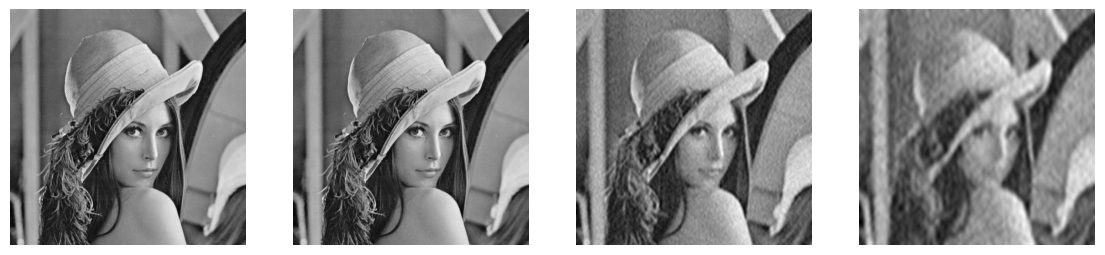

In [51]:
plt.figure(figsize=(14, 8))

plt.subplot(1, len(factors_to_show) + 1, 1)
plt.imshow(original_gray_image, cmap='gray')
plt.axis('off')

for j, factor in enumerate(factors_to_show, start=1):
    index = np.argmin(np.abs(np.array(fourier_compression_factors) - factor))
    plt.subplot(1, len(factors_to_show) + 1, j + 1)
    plt.imshow(fourier_compressed_images[index], cmap='gray')
    plt.axis('off')

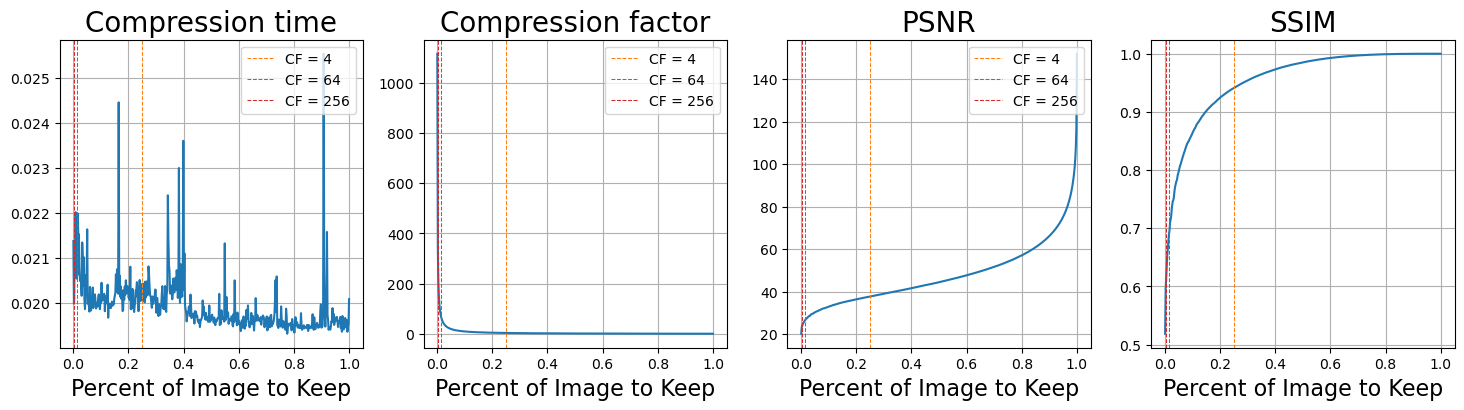

In [52]:
indexes = [np.argmin(np.abs(np.array(fourier_compression_factors) - factor)) for factor in factors_to_show]

plt.figure(figsize=(18, 4))

ax = plt.subplot(1, 4, 1)
plt.plot(keeps, fourier_compression_times)
for index in indexes:
    plt.axvline(keeps[index], color=next(ax._get_lines.prop_cycler)['color'], linestyle='dashed', linewidth=0.75, label=f'CF = {int(fourier_compression_factors[index])}')
plt.title(f'Compression time', fontsize = 20)
plt.xlabel('Percent of Image to Keep', fontsize = 16)
plt.legend(loc='upper right')
plt.grid(True)

ax = plt.subplot(1, 4, 2)
plt.plot(keeps, fourier_compression_factors)
for index in indexes:
    plt.axvline(keeps[index], color=next(ax._get_lines.prop_cycler)['color'], linestyle='dashed', linewidth=0.75, label=f'CF = {int(fourier_compression_factors[index])}')
plt.title(f'Compression factor', fontsize = 20)
plt.xlabel('Percent of Image to Keep', fontsize = 16)
plt.legend(loc='upper right')
plt.grid(True)

ax = plt.subplot(1, 4, 3)
plt.plot(keeps, fourier_psnrs)
for index in indexes:
    plt.axvline(keeps[index], color=next(ax._get_lines.prop_cycler)['color'], linestyle='dashed', linewidth=0.75, label=f'CF = {int(fourier_compression_factors[index])}')
plt.title(f'PSNR', fontsize = 20)
plt.xlabel('Percent of Image to Keep', fontsize = 16)
plt.legend(loc='upper right')
plt.grid(True)

ax = plt.subplot(1, 4, 4)
plt.plot(keeps, fourier_ssims)
for index in indexes:
    plt.axvline(keeps[index], color=next(ax._get_lines.prop_cycler)['color'], linestyle='dashed', linewidth=0.75, label=f'CF = {int(fourier_compression_factors[index])}')
plt.title(f'SSIM', fontsize = 20)
plt.xlabel('Percent of Image to Keep', fontsize = 16)
plt.grid(True)

# Discrete Cosine Transform

In [53]:
def dct_compress_image_with_thresh(original_image, keep):
    coeffs = dctn(original_image, norm='ortho')
    Csort = np.sort(np.abs(coeffs.reshape(-1)))

    thresh = Csort[int(np.floor((1 - keep) * len(Csort)))]
    ind = np.abs(coeffs) > thresh
    Cfiltered = coeffs * ind

    return Cfiltered

def dct_reconstruct_image(coeffs):
    return idctn(coeffs, norm='ortho')

def dct_statistics(original_image, keep):
    Cfiltered = dct_compress_image_with_thresh(original_image, keep)

    compr_time = average_time(dct_compress_image_with_thresh, original_image, keep)
    compr_factor = compression_factor(Cfiltered.size, np.sum(np.abs(Cfiltered) > 0))

    reconstructed_image = dct_reconstruct_image(Cfiltered)

    psnr_ = psnr(original_image, reconstructed_image, data_range=original_image.max() - reconstructed_image.min())
    ssim_ = ssim(original_image, reconstructed_image, data_range=original_image.max() - reconstructed_image.min())

    return reconstructed_image, compr_time, compr_factor, psnr_, ssim_

In [54]:
dct_compressed_images = list()
dct_compression_times = list()
dct_compression_factors = list()
dct_psnrs = list()
dct_ssims = list()

for keep in keeps:
    dct_compr_image, dct_compr_time, dct_compr_factor, dct_psnr, dct_ssim = dct_statistics(original_gray_image, keep)

    dct_compressed_images.append(dct_compr_image)
    dct_compression_times.append(dct_compr_time)
    dct_compression_factors.append(dct_compr_factor)
    dct_psnrs.append(dct_psnr)
    dct_ssims.append(dct_ssim)

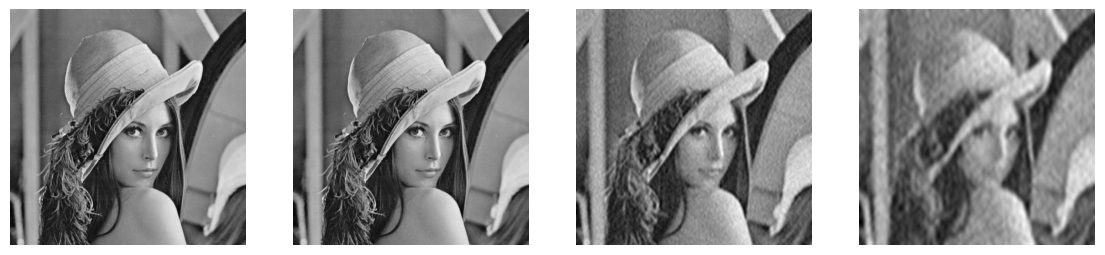

In [55]:
plt.figure(figsize=(14, 8))

plt.subplot(1, len(factors_to_show) + 1, 1)
plt.imshow(original_gray_image, cmap='gray')
plt.axis('off')

for j, factor in enumerate(factors_to_show, start=1):
    index = np.argmin(np.abs(np.array(dct_compression_factors) - factor))
    plt.subplot(1, len(factors_to_show) + 1, j + 1)
    plt.imshow(dct_compressed_images[index], cmap='gray')
    plt.axis('off')

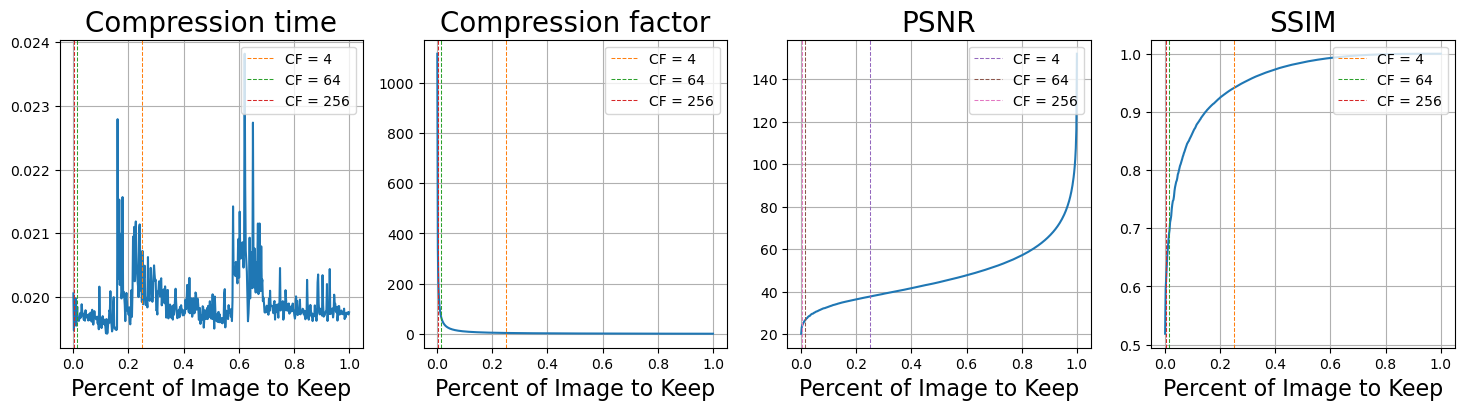

In [56]:
indexes = [np.argmin(np.abs(np.array(dct_compression_factors) - factor)) for factor in factors_to_show]

plt.figure(figsize=(18, 4))

ax = plt.subplot(1, 4, 1)
plt.plot(keeps, dct_compression_times)
for index in indexes:
    plt.axvline(keeps[index], color=next(ax._get_lines.prop_cycler)['color'], linestyle='dashed', linewidth=0.75, label=f'CF = {int(dct_compression_factors[index])}')
plt.title(f'Compression time', fontsize = 20)
plt.xlabel('Percent of Image to Keep', fontsize = 16)
plt.legend(loc='upper right')
plt.grid(True)

ax = plt.subplot(1, 4, 2)
plt.plot(keeps, dct_compression_factors)
for index in indexes:
    plt.axvline(keeps[index], color=next(ax._get_lines.prop_cycler)['color'], linestyle='dashed', linewidth=0.75, label=f'CF = {int(dct_compression_factors[index])}')
plt.title(f'Compression factor', fontsize = 20)
plt.xlabel('Percent of Image to Keep', fontsize = 16)
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(1, 4, 3)
plt.plot(keeps, dct_psnrs)
for index in indexes:
    plt.axvline(keeps[index], color=next(ax._get_lines.prop_cycler)['color'], linestyle='dashed', linewidth=0.75, label=f'CF = {int(dct_compression_factors[index])}')
plt.title(f'PSNR', fontsize = 20)
plt.xlabel('Percent of Image to Keep', fontsize = 16)
plt.legend(loc='upper right')
plt.grid(True)

ax = plt.subplot(1, 4, 4)
plt.plot(keeps, dct_ssims)
for index in indexes:
    plt.axvline(keeps[index], color=next(ax._get_lines.prop_cycler)['color'], linestyle='dashed', linewidth=0.75, label=f'CF = {int(dct_compression_factors[index])}')
plt.title(f'SSIM', fontsize = 20)
plt.xlabel('Percent of Image to Keep', fontsize = 16)
plt.legend(loc='upper right')
plt.grid(True)